In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import sklearn_crfsuite
from sklearn_crfsuite import metrics
from mlxtend.plotting import plot_confusion_matrix

In [2]:
df = pd.read_csv("/mnt/d/work2/teknofest-tddi/data/processed/all_tagged_aspects_just_aspect_cleaned_sentences.csv")
df.head()

,sentence,word_labels
0,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,"O,O,B-A,O,O,O,O,B-A,O,O,O"
1,Her güncellemede daha da kötüleşen Turkcell in...,"O,O,O,O,O,B-A,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
2,BiP’ten aranmıyor yardım,"B-A,O,O"
3,Bu yorumum kesinlikle uygulamanın daha çok gel...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-A,O,O,O,..."
4,kurumlarda WhatsApp engelleniyor Alternatif ol...,"O,B-A,O,O,O,B-A,O,O,B-A,O,O,O,O,O,O,O,B-A,O,O,..."


In [3]:
df.shape

(113203, 2)

In [4]:
def create_sentences_and_labels(df):
    sentences = df['sentence'].apply(lambda x: x.split())
    labels = df['word_labels'].apply(lambda x: x.split(','))
    return [(list(zip(sent, lab))) for sent, lab in zip(sentences, labels)]

In [5]:
sentences_and_labels = create_sentences_and_labels(df)

In [6]:
def train_validate_test_split(df, split_size):
    perm = np.random.permutation(df.index)
    train_end = int(train_size * len(df.index))
    validate_end = int(((1 - split_size) / 2) * len(df.index)) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [15]:
train_sents, test_sents = train_test_split(sentences_and_labels, test_size=0.1, random_state=42)

In [16]:
def word2features(sent, i):
    word = sent[i][0]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of Sentence
    
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True  # End of Sentence

    return features

In [17]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

In [18]:
def sent2labels(sent):
    return [label for token, label in sent]

In [19]:
def sent2tokens(sent):
    return [token for token, label in sent]

In [20]:
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

In [21]:
X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

In [22]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=False
)

In [24]:
%%time

crf.fit(X_train, y_train)

CPU times: user 1min 16s, sys: 256 ms, total: 1min 16s
Wall time: 1min 16s


CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,
    max_iterations=100)

In [25]:
%%time

y_pred = crf.predict(X_test)

CPU times: user 639 ms, sys: 0 ns, total: 639 ms
Wall time: 638 ms


In [26]:
labels = list(crf.classes_)

print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3
))

              precision    recall  f1-score   support

         B-A      0.995     0.986     0.991     15957
           O      0.999     1.000     0.999    211139
         I-A      0.929     0.875     0.901       640

    accuracy                          0.998    227736
   macro avg      0.974     0.954     0.964    227736
weighted avg      0.998     0.998     0.998    227736



In [27]:
model_precision_score = metrics.flat_precision_score(y_test, y_pred, average="macro")
model_f1_score = metrics.flat_f1_score(y_test, y_pred, average="macro")
model_recall_score = metrics.flat_recall_score(y_test, y_pred, average="macro")
model_accuracy_score = metrics.flat_accuracy_score(y_test, y_pred)

print(f"Bi-GRU Precision Score = {model_precision_score * 100:.4f}%")
print(f"Bi-GRU F1 Score = {model_f1_score * 100:.4f}%")
print(f"Bi-GRU Recall Score = {model_recall_score * 100:.4f}%")
print(f"Bi-GRU Accuracy Score = {model_accuracy_score * 100:.4f}%")

Bi-GRU Precision Score = 97.4264%
Bi-GRU F1 Score = 96.3669%
Bi-GRU Recall Score = 95.3620%
Bi-GRU Accuracy Score = 99.8248%


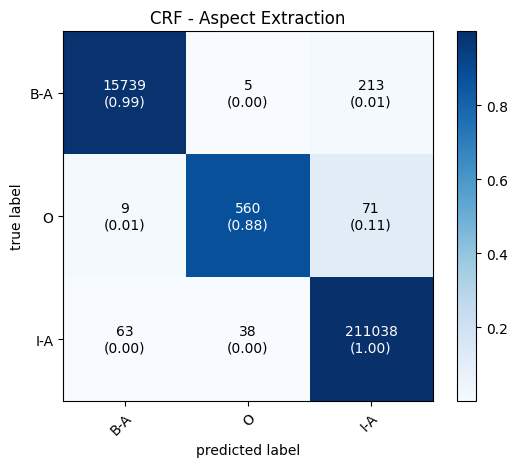

In [28]:
cm = confusion_matrix(y_true = metrics.flatten(y_test), y_pred = metrics.flatten(y_pred))
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True, class_names=list(crf.classes_))
plt.title("CRF - Aspect Extraction")
plt.savefig("./output/crf.png")
plt.show()